# ОЦЕНКА РЕЗУЛЬТАТОВ А/В ТЕСТА
# ТЕСТИРОВАНИЕ ИЗМЕНЕНИЙ, СВЯЗАННЫХ С ВНЕДРЕНИЕМ УЛУЧШЕННОЙ РЕКОМЕНДАТЕЛЬНОЙ СИСТЕМЫ

**ЗАДАЧА ПРОЕКТА:**

на основании данных:

1. **файл ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год**

Структура файла:

* name — название маркетингового события
* regions — регионы, в которых будет проводиться рекламная кампания
* start_dt — дата начала кампании
* finish_dt — дата завершения кампании

2. **файл final_ab_new_users.csv — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года**

Структура файла:

* user_id — идентификатор пользователя
* first_date — дата регистрации
* region — регион пользователя
* device — устройство, с которого происходила регистрация

3. **файл final_ab_events.csv — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года**

Структура файла:

* user_id — идентификатор пользователя
* event_dt — дата и время покупки
* event_name — тип события
* details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах

4. **файл final_ab_participants.csv — таблица участников тестов**

Структура файла:

* user_id — идентификатор пользователя
* ab_test — название теста
* group — группа пользователя

**Оценить** корректность проведения теста

**Проанализировать** результаты теста

**ТЕХНИЧЕСКОЕ ЗАДАНИЕ:**

* Название теста: recommender_system_test
* группы: А — контрольная, B — новая платёжная воронка
* дата запуска: 2020-12-07
* дата остановки набора новых пользователей: 2020-12-21
* дата остановки: 2021-01-04
* аудитория: 15% новых пользователей из региона EU
* назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы
* ожидаемое количество участников теста: 6 000
* ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%
* конверсии в просмотр карточек товаров — событие product_page
* просмотры корзины — product_cart
* покупки — purchase

## Предподготовка данных

**Задача:**

* создание рабочей среды
* загрузка данных
* проверка регистров, корректности записей и названий (преобразования в случае необходимости)
* проверка типов данных ((преобразования в случае необходимости)
* проверка пропущенных значений (преобразования в случае необходимости)
* проверка дубликатов (преобразования в случае необходимости)
* проверка минимальных и максимальных значений на аномалии (преобразования в случае необходимости)

In [1]:
# импортируем библиотеки, подготавливаем рабочую среду

import pandas as pd
from scipy import stats as st
from scipy.stats import ttest_ind
import numpy as np
import math as mth
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 110)

In [2]:
# загружаем данные датасета ab_project_marketing_events.csv,
# выводим информацию о датасете,
# выводим случайные 5 строк таблицы

data_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
data_marketing_events.info()
display(data_marketing_events.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [3]:
# загружаем данные датасета final_ab_new_users.csv,
# выводим информацию о датасете,
# выводим случайные 5 строк таблицы

data_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
data_new_users.info()
display(data_new_users.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
24631,5416B27667290330,2020-12-22,N.America,Android
5914,73D9C981F58F142C,2020-12-14,EU,Mac
20963,F353A2103A841CC9,2020-12-15,N.America,Android
12406,445D0721DD9E5383,2020-12-21,EU,PC
5806,737E455A75A554D9,2020-12-14,EU,iPhone


In [4]:
# загружаем данные датасета final_ab_events.csv,
# выводим информацию о датасете,
# выводим случайные 5 строк таблицы

data_events = pd.read_csv('/datasets/final_ab_events.csv')
data_events.info()
display(data_events.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
147210,CFC391588F9B5725,2020-12-12 03:39:55,product_page,NaN
396349,04169EDF8C3E29D5,2020-12-23 04:59:16,login,NaN
175537,D6A064E1EE0A32DA,2020-12-17 04:14:10,product_page,NaN
404463,F97E92F5603B56CD,2020-12-24 20:29:07,login,NaN
19889,D60249423BFF4B95,2020-12-15 11:04:57,purchase,4.99


In [5]:
# загружаем данные датасета final_ab_participants.csv,
# выводим информацию о датасете,
# выводим случайные 5 строк таблицы

data_participants = pd.read_csv('/datasets/final_ab_participants.csv')
data_participants.info()
display(data_participants.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
6977,D673BA7586699E6B,A,interface_eu_test
16914,E38564BBA19337BE,A,interface_eu_test
501,179F49110E880D42,A,recommender_system_test
15769,88D1DFF676F76332,B,interface_eu_test
7821,5D689ED21CBB26CC,B,interface_eu_test


In [6]:
# создаем циклы,
# приводим данные в таблицах data_marketing_events, data_new_users, data_events, data_participants к нижнему регистру,
# таблицу data_events обрабатываем отдельно, т.к. она имеет в своем составе тип данных float64

for df in [data_marketing_events, data_new_users, data_participants]:
    for column in df:
        df[column] = df[column].str.lower()
    display(df.head(2))

for column in ['user_id', 'event_dt', 'event_name']:
    data_events[column] = data_events[column].str.lower()
display(data_events.head(2))  

,name,regions,start_dt,finish_dt
0,christmas&new year promo,"eu, n.america",2020-12-25,2021-01-03
1,st. valentine's day giveaway,"eu, cis, apac, n.america",2020-02-14,2020-02-16


,user_id,first_date,region,device
0,d72a72121175d8be,2020-12-07,eu,pc
1,f1c668619dfe6e65,2020-12-07,n.america,android


,user_id,group,ab_test
0,d1aba3e2887b6a73,a,recommender_system_test
1,a7a3664bd6242119,a,recommender_system_test


,user_id,event_dt,event_name,details
0,e1bddce0dafa2679,2020-12-07 20:22:03,purchase,99.99
1,7b6452f081f49504,2020-12-07 09:22:53,purchase,9.99


In [7]:
# приводим данные о датах в таблицах data_marketing_events, data_new_users, data_events к типу 'datetime64'

data_marketing_events['start_dt'] = pd.to_datetime(data_marketing_events['start_dt'], yearfirst=True)
data_marketing_events['finish_dt'] = pd.to_datetime(data_marketing_events['finish_dt'], yearfirst=True)
display(data_marketing_events.dtypes)

data_events['event_dt'] = pd.to_datetime(data_events['event_dt'], yearfirst=True)
display(data_events.dtypes)

data_new_users['first_date'] = pd.to_datetime(data_new_users['first_date'], yearfirst=True)
display(data_new_users.dtypes)

name                 object
regions              object
start_dt     datetime64[ns]
finish_dt    datetime64[ns]
dtype: object

user_id               object
event_dt      datetime64[ns]
event_name            object
details              float64
dtype: object

user_id               object
first_date    datetime64[ns]
region                object
device                object
dtype: object

In [8]:
# создаем цикл,
# проверяем наличие пропусков в таблицах data_marketing_events, data_new_users, data_events, data_participants

for df in [data_marketing_events, data_new_users, data_participants, data_events]:
    print('Количество пропущенных значений в таблице:\n',df.isna().sum())


Количество пропущенных значений в таблице:
 name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
Количество пропущенных значений в таблице:
 user_id       0
first_date    0
region        0
device        0
dtype: int64
Количество пропущенных значений в таблице:
 user_id    0
group      0
ab_test    0
dtype: int64
Количество пропущенных значений в таблице:
 user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64


In [9]:
# создаем цикл,
# проверяем наличие дубликатов в таблицах data_marketing_events, data_new_users, data_events, data_participants

for df in [data_marketing_events, data_new_users, data_participants, data_events]:
    print('Количество дубликатов в таблице:\n', df.duplicated().sum())


Количество дубликатов в таблице:
 0
Количество дубликатов в таблице:
 0
Количество дубликатов в таблице:
 0
Количество дубликатов в таблице:
 0


### Выводы

* информация представлена в 4-х датасетах:
>
> **календарь маркетинговых событий на 2020 год** - data_marketing_events = 14 записей в 4 колонках
>
> **пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года** - data_new_users = 61 733 записи в 4 колонках
>
> **действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года** - data_events = 440 317 записей в 4 колонках
>
> **таблица участников тестов** - data_participants = 18 268 записей в 3 колонках
>
* датасеты *data_new_users, data_events и data_participants* содержат уникальные номера пользователей *user_id* на основе которых возможно объединение информации
* назчания колонок во всех датасетах прописаны в ожидаемом формате
* в качестве преобразования все записи в датасетах приведены к нижнему регистру
* информация о датах в таблицах *data_marketing_events, data_new_users, data_events* приведена к типу *datetime64*
* пропуски присутствует только в талице *data_events* в колонке *details* = 377 577 пропусков
* дубликаты в таблицах не выявлены

## Исследовательский анализ данных EDA

**Задача:**
* проверить пересечение тестовой аудитории с конкурирующим тестом
* проверить принадлежность пользователей к региону EU
* проверить совпадение теста и меркетинговых событий
* определить наличие проблем временных границ теста
* проверить корректность распределения внутри теста между граппами А и В
* проанализировать изменение конверсии в воронке на разных этапах
* проверить эдентичность распределения кол-ва событий на пользователя в выборках
* проверить распределение числа событий по дням

### Проверка пересечения тестовой аудитории с конкурирующим тестом

In [10]:
# создаем таблицу на проверку пересечений уникального пользователя в разных тестах

data_test_split = data_participants.pivot_table(index = 'user_id', columns = 'ab_test', values = 'group', aggfunc = 'count')
display(data_test_split.sample(2))

# добавляем колонку group_id:
# если сумма = 1, пользователь встречается только в 1 группе, если 2 - в обеих группах,
# выводим кол-во участников в каждой группе тестов

data_test_split['group_id'] = data_test_split.sum(axis=1)
display(data_test_split.groupby('group_id').agg({'interface_eu_test':'sum', 'recommender_system_test':'sum'}))

ab_test,interface_eu_test,recommender_system_test
user_id,,
bdd4ac0ca848f33a,1.0,NaN
4e24530ab40d2101,NaN,1.0


,interface_eu_test,recommender_system_test
group_id,,
1.0,9965.0,5099.0
2.0,1602.0,1602.0


**Выводы по расчетам:**
* всего информация о распределении по группам и по тестам представлена о **16 666** пользоватеях
* **interface_eu_test** получил список из 9 965 уникальных пользователей
* **recommender_system_test** (интересуемый нас тест) получил список из 5 099 уникальных пользователей, что не совпадает с техническим задаем, согласно которому *ожидаемое количество участников теста: 6 000*
* 1 602 пользователя оказались распределенными в оба теста
* если даты тестов совпадают или пересекаются, это может стать критической ошибкой, т.к. невозможно определить что именно: изменение интерфейса или изменения в рекмендательной системе повлияли на изменение конверсии по ключевым метрикам

### Проверка пользователей на принадлежность к региону EU

In [11]:
# создаем список уникальных пользователей, распределенных в recommender_system_test

test_user_id_pure = data_test_split[(data_test_split['recommender_system_test'] == 1)\
                               & (data_test_split['interface_eu_test'] != 1)]
display(test_user_id_pure.shape)

(5099, 3)

In [12]:
# объединяем таблицы test_user_id_pure и data_new_users,
# проверяем рспределение пользователей по регионам

test_user_id_pure_reg = test_user_id_pure.merge(data_new_users, on = 'user_id', how = 'left')
display(test_user_id_pure_reg.groupby('region').agg({'user_id':'nunique'}))

,user_id
region,
apac,72
cis,55
eu,4749
n.america,223


In [13]:
# согласно Техническому Заданию отфильтровываем пользователей не из региона EU

test_user_id_pure_reg_eu = test_user_id_pure_reg[test_user_id_pure_reg['region'] == 'eu']
display(test_user_id_pure_reg_eu.shape)
display(test_user_id_pure_reg_eu.sample(2))

(4749, 7)

,user_id,interface_eu_test,recommender_system_test,group_id,first_date,region,device
3873,c13e8869b81d02ff,NaN,1.0,1.0,2020-12-20,eu,mac
1362,4532216377f3aaf1,NaN,1.0,1.0,2020-12-15,eu,android


In [14]:
# создаем список перекрестных пользователей, распределенных в оба теста

test_user_id_mix = data_test_split[(data_test_split['recommender_system_test'] == 1)\
                               & (data_test_split['interface_eu_test'] == 1)]
display(test_user_id_mix.shape)
display(test_user_id_mix.sample(2))

(1602, 3)

ab_test,interface_eu_test,recommender_system_test,group_id
user_id,,,
958426148afa05c5,1.0,1.0,2.0
c4876a46378bf2e7,1.0,1.0,2.0


In [15]:
# объединяем таблицы test_user_id и data_new_users,
# проверяем рспределение пользователей по регионам

test_user_id_mix_reg = test_user_id_mix.merge(data_new_users, on = 'user_id', how = 'left')
display(test_user_id_mix_reg.groupby('region').agg({'user_id':'nunique'}))

,user_id
region,
eu,1602


**Выводы по расчетам:**
* выборка уникальных пользователей, отобранных для теста recommender_system_test показала, что в список попали 350 пользователей не из региона EU, что противоречит Техническому Заданию
* уникальные пользователи не из региона EU были отфильтрованы и список участников теста сократился до 4 749 уникальных пользователей
* проверка пользователей, распределенных в оба теста, показала, что они все из региона EU

### Проверка дат регистрации пользователей - участников теста 

In [16]:
# проверяем даты регистрации уникальных пользователей
# делаем выборку уникальных пользователей нашего теста из общего списка зарегистрированных пользователей,
# фильтруем выборку согласно технического Задания (дата запуска: 2020-12-07,
# дата остановки набора новых пользователей: 2020-12-21)

df_pure = data_new_users[(data_new_users['user_id'].isin(test_user_id_pure_reg_eu['user_id']))]

df_pure = df_pure[df_pure['first_date'].between('2020-12-07', '2020-12-21')]
display(df_pure.shape)

(4749, 4)

In [17]:
# проверяем даты регистрации пользователей, распределенных в оба теста
# делаем выборку пересекшихся пользователей из общего списка зарегистрированных пользователей,
# фильтруем выборку согласно технического Задания (дата запуска: 2020-12-07,
# дата остановки набора новых пользователей: 2020-12-21)

df_mix = data_new_users[(data_new_users['user_id'].isin(test_user_id_mix.index))]

df_mix = df_mix[df_mix['first_date'].between('2020-12-07', '2020-12-21')]
display(df_mix.shape)

(1602, 4)

**выводы по расчетам:**
* проверка дат регистрации не выявила в списке теста пользователей, которые зарегистрировались вне периода эксперимента

### Проверка пересечения с маркетинговыми событиями

In [18]:
# выводим события, которые накладываются на даты проведения теста

data_marketing_events_focus = data_marketing_events[data_marketing_events['finish_dt'] > '2020-12-07']
display(data_marketing_events_focus)

,name,regions,start_dt,finish_dt
0,christmas&new year promo,"eu, n.america",2020-12-25,2021-01-03
10,cis new year gift lottery,cis,2020-12-30,2021-01-07


**Выводы по вычислениям:**
* по датам и по региону проведения тест совпадает с новогодним промо, что может исказить результаты теста

### Проверка наличия событий у уникальных пользователей во время эксперимента

In [19]:
# проверяем кол-во уникальных пользователей, закрепленных за тестом,
# которые осуществили действия во время эксперимента

data_events_test_pure = data_events[data_events['user_id'].isin(test_user_id_pure_reg_eu['user_id'])]

display(data_events_test_pure.groupby('event_name')['user_id'].nunique().reset_index())

,event_name,user_id
0,login,2594
1,product_cart,773
2,product_page,1632
3,purchase,804


In [20]:
# проверяем кол-во миксованных пользователей, закрепленных за тестом,
# которые осуществили действия во время эксперимента

data_events_test_mix = data_events[data_events['user_id'].isin(test_user_id_mix.index)]

display(data_events_test_mix.groupby('event_name')['user_id'].nunique().reset_index())

,event_name,user_id
0,login,887
1,product_cart,253
2,product_page,546
3,purchase,278


**Выводы по расчетам:**
* из 4 749 уникальных пользователей, распределенных в recommender_system_test, только 2 594 пользователя совершили хотя бы 1 действие
* 2 155 пользователей не совершили действий, соответственно не могут принять учестие в оценке результатов
* из 1 602 миксованных пользователей, распределенных в оба теста, 887 пользователя совершили хотя бы 1 действие
* 715 пользователей не совершили действий, соответственно не могут принять учестие в оценке результатов

### Формирование пула событий, совершенных в рамках эксперимента

In [21]:
# делаем выборку событий по уникальным пользователям, закрепленным за тестом, и по датам эксперимента,
# добавляем колонку с датой

data_events_test_dt_pure = data_events_test_pure[data_events_test_pure['event_dt'].between('2020-12-07', '2021-04-01')]
data_events_test_dt_pure['date'] = pd.DatetimeIndex(data_events_test_pure['event_dt']).date.astype('datetime64[ns]')

# выводим информацию о кол-ве уникальных пользователей,
# осуществивших действия в дату эксперимента

display(data_events_test_dt_pure.groupby('date')['user_id'].nunique().reset_index())

,date,user_id
0,2020-12-07,222
1,2020-12-08,190
2,2020-12-09,245
3,2020-12-10,202
4,2020-12-11,187
5,2020-12-12,203
6,2020-12-13,170
7,2020-12-14,434
8,2020-12-15,422
9,2020-12-16,450


In [22]:
# делаем выборку событий по миксованным пользователям, закрепленным за тестом, и по датам эксперимента,
# добавляем колонку с датой

data_events_test_dt_mix = data_events_test_mix[data_events_test_mix['event_dt'].between('2020-12-07', '2021-04-01')]
data_events_test_dt_mix['date'] = pd.DatetimeIndex(data_events_test_mix['event_dt']).date.astype('datetime64[ns]')

# выводим информацию о кол-ве уникальных пользователей,
# осуществивших действия в дату эксперимента

display(data_events_test_dt_mix.groupby('date')['user_id'].nunique().reset_index())

,date,user_id
0,2020-12-07,89
1,2020-12-08,71
2,2020-12-09,87
3,2020-12-10,78
4,2020-12-11,73
5,2020-12-12,67
6,2020-12-13,65
7,2020-12-14,147
8,2020-12-15,139
9,2020-12-16,157


In [23]:
# проверяем действия, осуществленные 2020-12-30 как уникальными, так и миксованными пользователями

display(data_events_test_dt_pure[data_events_test_dt_pure['date'] == '2020-12-30'])
display(data_events_test_dt_mix[data_events_test_dt_mix['date'] == '2020-12-30'])

,user_id,event_dt,event_name,details,date
125187,75845c83258fbf73,2020-12-30 06:42:52,product_cart,NaN,2020-12-30
440289,75845c83258fbf73,2020-12-30 06:42:52,login,NaN,2020-12-30


,user_id,event_dt,event_name,details,date
250743,dd4352cdcf8c3d57,2020-12-30 12:42:57,product_page,NaN,2020-12-30
440281,dd4352cdcf8c3d57,2020-12-30 12:42:56,login,NaN,2020-12-30


**Выводы по расчетам:**
* предоставленная информация содерджит данные о действиях уникальных и миксованных пользователей, закрепленных за тестом, за период с 2020-12-07 по 2020-12-30
* согласно Технического Задания ожидаемый эффект должен рассчитываться за 14 дней с момента регистрации пользователей
* выявленное обстоятельство влияет на качество теста, сокращая реальное кол-во пользователей, принявших участие в эксперименте

### Проверка распределения миксованных пользователей по А/В группам в конкурирующем тесте

In [24]:
# делаем выборку по миксованным клиентам

data_participants_mix = data_participants[data_participants['user_id'].isin(test_user_id_mix.index)]

# проверяем распределени по А/В группам в тесте interface_eu_test

display(data_participants_mix.pivot_table(index='ab_test', columns='group', values='user_id', aggfunc=('nunique'))\
        .reset_index())

group,ab_test,a,b
0,interface_eu_test,819,783
1,recommender_system_test,921,681


**Выводы по рачетам:**
* миксованные пользователи оказались практически равномерно распределены мжду А/В группами в конкурирующем тесте
* 783 пользователя, попавшие в тестовую группу В эксперимента по изменению интерфейса, очевидно оказались по влиянием этого эксперимента

### Промежуточные выводы

По выявленным фактам аномалий в данных приняты следующие решения:
* **1 602** пользователя, которые оказались одновременно закрепленными за 2-мя параллельно проводимыми тестами - **оставить в выборке** для дальнейшего исследования; проверить равномерность распределения этих пользователей по А/В группам внутри интересующего нас теста
* **350** пользователей, не принадлежащих к региону EU - **исключить из выборки**, т.к. это противоречит Техническому Заданию
* 

### Формирование финальной выборки пользователей и оценка распределений по А/В группам

In [25]:
# объединяем таблицы data_participants и data_new-users

data_test_users = data_participants.merge(data_new_users, on = 'user_id', how = 'left')

# делаем выборку по наименованию теста recommender_system_tes и региону eu

test_users = data_test_users[(data_test_users['ab_test'] == 'recommender_system_test') & (data_test_users['region'] == 'eu')]

print('Кол-во уникальных клиентов в выборке для исследования:', test_users['user_id'].nunique())
display(test_users.sample(2))

Кол-во уникальных клиентов в выборке для исследования: 6351


,user_id,group,ab_test,first_date,region,device
3170,36b2004f6a1c76df,a,recommender_system_test,2020-12-20,eu,iphone
4131,c3eebf6dbc3384fa,b,recommender_system_test,2020-12-18,eu,android


In [26]:
# проверяем выборку в общем на распределение между А/В группами

display(test_users.groupby('group').agg({'user_id':'nunique'}).reset_index())

,group,user_id
0,a,3634
1,b,2717


In [27]:
# проверяем вошедших в выборку миксованных пользователей на распределение по А/В группам

display(test_users[test_users['user_id'].isin(df_mix['user_id'])].groupby('group').agg({'user_id':'nunique'}).reset_index())

,group,user_id
0,a,921
1,b,681


**Выводы по расчетам:**
* распределение всех пользователей на группы прошло в соотношении: **группа А - контрольная** = 57% / **группа В - тестовая** = 43%
* **миксованые клиенты в группе А** составили 25%
* **миксованные клиенты в группе В** составили 25%


In [28]:
# проверяем долю попавших в тест пользователей из региона eu от общего кол-ва пользователей региона eu

eu_test_share = test_users['user_id'].nunique() / data_new_users[data_new_users['region'] == 'eu']['user_id'].nunique()
print('Доля тестовой выборки в общем кол-ве пользователей из EU {} %:'.format(eu_test_share*100))

Доля тестовой выборки в общем кол-ве пользователей из EU 13.725956343202938 %:


**Выводы по расчетам:**
* доля пользователей, попавших в выборку, составила 14% от общего кол-ва пользователей из EU, что близко к значению Технического Задания

### Анализ изменения конверсии в воронке на разных этапах

In [29]:
# делаем полную выборку всех событий по тестовым пользователям

test_events = data_events[data_events['user_id'].isin(test_users['user_id'])]

# объединяем таблицы test_events и test_users,
# убираем не значимые для текущего анализа колонки,
# добавляем колонку event_date

test_data = test_events.merge(test_users, on = 'user_id', how = 'left')
test_data = test_data.drop(['details', 'region', 'ab_test'], axis=1)
test_data['event_date'] = pd.DatetimeIndex(test_data['event_dt']).date.astype('datetime64[ns]')

display(test_data[test_data['event_date'] >= '2020-12-21'])

,user_id,event_dt,event_name,group,first_date,device,event_date
1914,27802765d2458b2b,2020-12-21 23:07:31,purchase,a,2020-12-07,iphone,2020-12-21
1915,4efb5e89ac11ac6d,2020-12-21 04:40:03,purchase,b,2020-12-07,iphone,2020-12-21
1916,c48127e2fa8d4f18,2020-12-21 19:25:30,purchase,b,2020-12-07,iphone,2020-12-21
1917,89143f0aefe3b11d,2020-12-21 19:44:22,purchase,b,2020-12-07,iphone,2020-12-21
1918,0dd2e54d87cfd4a4,2020-12-21 16:52:35,purchase,a,2020-12-14,iphone,2020-12-21
...,...,...,...,...,...,...,...
23415,d21f0d4fdcd82db2,2020-12-29 02:17:00,login,a,2020-12-20,iphone,2020-12-29
23416,96bdd55846d1f7f6,2020-12-29 16:53:42,login,a,2020-12-20,iphone,2020-12-29
23417,553bae96c6eb6240,2020-12-29 14:09:14,login,a,2020-12-20,android,2020-12-29
23418,dd4352cdcf8c3d57,2020-12-30 12:42:56,login,b,2020-12-07,android,2020-12-30


In [30]:
# создаем массив уникальных пар значений дат и групп теста

datesGroups = test_data[['event_date', 'group']].drop_duplicates()

# получаем аггрегированные кумулятивные данные о кол-ве уникальных пользователей,
# совершивших действие login

test_data_login = test_data[test_data['event_name'] == 'login']
eventsAggregated_login = datesGroups.apply(lambda x: test_data_login[np.logical_and(test_data_login['event_date'] <= x['event_date']\
                                                                                    , test_data_login['group'] == x['group'])]\
                                           .agg({'event_date':'max', 'group':'max', 'user_id':'count'}), axis = 1)\
.sort_values(by = ['event_date', 'group'])

# получаем аггрегированные кумулятивные данные о кол-ве уникальных пользователей,
# совершивших действие productc_page

eventsAggregated_product_page = datesGroups.apply(lambda x: test_data[test_data['event_name'] == 'product_page']\
                                                  [np.logical_and(test_data['event_date'] <= x['event_date']\
                                                                       , test_data['group'] == x['group'])]\
                                    .agg({'event_date':'max', 'group':'max', 'user_id':'count'}), axis = 1)\
.sort_values(by = ['event_date', 'group'])

# получаем аггрегированные кумулятивные данные о кол-ве уникальных пользователей,
# совершивших действие productc_cart

eventsAggregated_product_cart = datesGroups.apply(lambda x: test_data[test_data['event_name'] == 'product_cart']\
                                                  [np.logical_and(test_data['event_date'] <= x['event_date']\
                                                                       , test_data['group'] == x['group'])]\
                                    .agg({'event_date':'max', 'group':'max', 'user_id':'count'}), axis = 1)\
.sort_values(by = ['event_date', 'group'])

# получаем аггрегированные кумулятивные данные о кол-ве уникальных пользователей,
# совершивших действие purchase

eventsAggregated_purchase = datesGroups.apply(lambda x: test_data[test_data['event_name'] == 'purchase']\
                                                  [np.logical_and(test_data['event_date'] <= x['event_date']\
                                                                       , test_data['group'] == x['group'])]\
                                    .agg({'event_date':'max', 'group':'max', 'user_id':'count'}), axis = 1)\
.sort_values(by = ['event_date', 'group'])

# объединяем аггрегированные данные,
# переименовываем колонки

eventsAggregated1 = eventsAggregated_login.merge(eventsAggregated_product_page, on = ['event_date', 'group'], how = 'left')
eventsAggregated2 = eventsAggregated1.merge(eventsAggregated_product_cart, on = ['event_date', 'group'], how = 'left')
eventsAggregated2 = eventsAggregated2.rename(columns=({'user_id_x':'login', 'user_id_y':'product_page'}))

eventsAggregated = eventsAggregated2.merge(eventsAggregated_purchase, on = ['event_date', 'group'], how = 'left')
eventsAggregated = eventsAggregated.rename(columns = {"user_id_x":'product_cart', 'user_id_y':'purchase'})

/tmp/ipykernel_55/133082967.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eventsAggregated_product_page = datesGroups.apply(lambda x: test_data[test_data['event_name'] == 'product_page']\
/tmp/ipykernel_55/133082967.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eventsAggregated_product_cart = datesGroups.apply(lambda x: test_data[test_data['event_name'] == 'product_cart']\
/tmp/ipykernel_55/133082967.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eventsAggregated_purchase = datesGroups.apply(lambda x: test_data[test_data['event_name'] == 'purchase']\


In [31]:
# считаем кумулятивную конверсию по метрикам

eventsAggregated['product_page_cumconv'] = (eventsAggregated['product_page'] / eventsAggregated['login']).round(2)
eventsAggregated['product_cart_cumconv'] = (eventsAggregated['product_cart'] / eventsAggregated['login']).round(2)
eventsAggregated['purchase_cumconv'] = (eventsAggregated['purchase'] / eventsAggregated['login']).round(2)

# отделяем данные по группам А и В
eventsAggregated_A = eventsAggregated[eventsAggregated['group'] == 'a']
eventsAggregated_B = eventsAggregated[eventsAggregated['group'] == 'b']

In [32]:
# выводим данные кумулятивной конверсии

display(eventsAggregated)

,event_date,group,login,product_page,product_cart,purchase,product_page_cumconv,product_cart_cumconv,purchase_cumconv
0,2020-12-07,a,148,92,35,43.0,0.62,0.24,0.29
1,2020-12-07,b,155,101,41,59.0,0.65,0.26,0.38
2,2020-12-08,a,294,190,71,76.0,0.65,0.24,0.26
3,2020-12-08,b,268,162,72,92.0,0.60,0.27,0.34
4,2020-12-09,a,465,293,121,123.0,0.63,0.26,0.26
5,2020-12-09,b,429,261,111,131.0,0.61,0.26,0.31
6,2020-12-10,a,621,381,166,165.0,0.61,0.27,0.27
7,2020-12-10,b,553,328,143,157.0,0.59,0.26,0.28
8,2020-12-11,a,797,477,210,205.0,0.60,0.26,0.26
9,2020-12-11,b,637,373,159,173.0,0.59,0.25,0.27


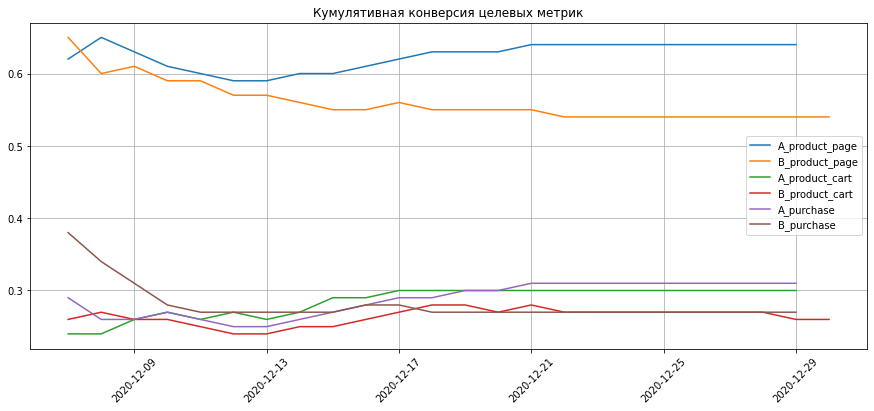

In [33]:
# строим график кумулятивной конверсии по целевым действиям

plt.figure(figsize=(15, 6))
plt.plot(eventsAggregated_A['event_date'], eventsAggregated_A['product_page_cumconv'], label = "A_product_page")
plt.plot(eventsAggregated_B['event_date'], eventsAggregated_B['product_page_cumconv'], label = "B_product_page")

plt.plot(eventsAggregated_A['event_date'], eventsAggregated_A['product_cart_cumconv'], label = "A_product_cart")
plt.plot(eventsAggregated_B['event_date'], eventsAggregated_B['product_cart_cumconv'], label = "B_product_cart")

plt.plot(eventsAggregated_A['event_date'], eventsAggregated_A['purchase_cumconv'], label = "A_purchase")
plt.plot(eventsAggregated_B['event_date'], eventsAggregated_B['purchase_cumconv'], label = "B_purchase")

plt.title('Кумулятивная конверсия целевых метрик')
plt.legend()
plt.grid(True)
plt.xticks(rotation = 45)

plt.show()

**Выводы по графику:**
* по всем целевым метрикам кумулятивная конверсия группы А (контрольной) показала лучший результат, чем конверсия группы В (тестовой)
* **метрика product_page**: на старте, в первый день эксперимента, показания группы В оказались выше, на второй день тренды пересеклись, до 12 декабря были параллельные колебания на сближение и удаление, далее группы стали удаляться друг от друга, группа В зафиксировалась 18 декабря, группа А зафиксировалась 21 декабря, последующие 8 дней группы шли параллельно - группа А с существенно лучшим результатом
* **метрика product_cart** - на старте, в первый день эксперимента, показания группы В оказались выше, на второй день тренды пересеклись, до 17 декабря были параллельные колебания на сближение и удаление, далее группы зафиксировались и последующие 12 дней шли параллельно - группа А с лучшим результатом
* **метрика purchase** - на старте конверсия группы В ведет себя существенно лучше, чем конверсия группы А, до 13 декабря происходят колебания на сближение и удаление, 13 декабря у группы А начинается стремительный рост, 15 декабря тренды пересекаются и группа А начинает доминировать, 18 декабря фиксируется группа В, 19 декабря фиксируется группа А, далее группы идут параллельно - группа А с лучшим результатом

### Оценка ожидаемого эффекта

* **ожидаемый эффект:** за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%

In [34]:
# добавляем к таблице test_data колонку last_test_date,
# определяем горизонт для ресчета эффекта по каждому пользователю

test_data['last_test_date'] = (test_data['first_date'] + timedelta(days=14))

display(test_data['last_test_date'].min(), test_data['last_test_date'].max())

Timestamp('2020-12-21 00:00:00')

Timestamp('2021-01-04 00:00:00')

In [35]:
# в связи с отсутствием данных о событиях после 2020-12-30,
# определяем дату последней регистрации, приемлемую для расчета эффективности

test_data['last_reg_date'] = (test_data['event_date'].max() - timedelta(days=13))
display(test_data.head(2))

,user_id,event_dt,event_name,group,first_date,device,event_date,last_test_date,last_reg_date
0,831887fe7f2d6cba,2020-12-07 06:50:29,purchase,a,2020-12-07,android,2020-12-07,2020-12-21,2020-12-17
1,3c5dd0288ac4fe23,2020-12-07 19:42:40,purchase,a,2020-12-07,pc,2020-12-07,2020-12-21,2020-12-17


In [36]:
# делаем выборку по пользователям и событиям,
# подходящим под критерий расчета эффективности за 14 дней

test_data_impact_check1 = test_data[(test_data['first_date'] <= test_data['last_reg_date'])\
                                   & (test_data['event_date'] <= test_data['last_test_date'])]

print('Диапазон дат регистрции:\n', test_data_impact_check1['first_date'].min(), test_data_impact_check1['first_date'].max())
print()
print('Диапазон дат событий:\n', test_data_impact_check1['event_date'].min(), test_data_impact_check1['event_date'].max())

Диапазон дат регистрции:
 2020-12-07 00:00:00 2020-12-17 00:00:00

Диапазон дат событий:
 2020-12-07 00:00:00 2020-12-29 00:00:00


In [37]:
# аггрегируем данные по кол-ву уникальных пользователей в каждой группе,
# совершивших целевые действия за установленный период расчета эффективности

test_data_impact_check = test_data_impact_check1.pivot_table(index='group'\
                                                             , columns='event_name', values = 'user_id', aggfunc = 'nunique')

display(test_data_impact_check)

event_name,login,product_cart,product_page,purchase
group,,,,
a,1515,458,962,462
b,639,187,365,183


In [38]:
# добавляем колонки с расчетом конверсии в целевые действия

test_data_impact_check['product_cart_impactconv'] = test_data_impact_check['product_cart'] / test_data_impact_check['login']
test_data_impact_check['product_page_impactconv'] = test_data_impact_check['product_page'] / test_data_impact_check['login']
test_data_impact_check['purchase_impactconv'] = test_data_impact_check['purchase'] / test_data_impact_check['login']

display(test_data_impact_check.T)

group,a,b
event_name,,
login,1515.000000,639.000000
product_cart,458.000000,187.000000
product_page,962.000000,365.000000
purchase,462.000000,183.000000
product_cart_impactconv,0.302310,0.292645
product_page_impactconv,0.634983,0.571205
purchase_impactconv,0.304950,0.286385


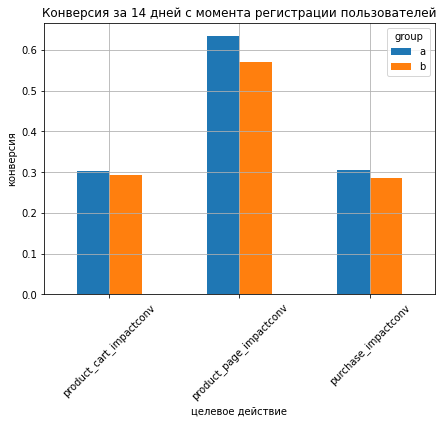

In [39]:
# строим столбчатую диаграмму для визуализации конверсии по целевым метрикам

test_data_impact_check[['product_cart_impactconv', 'product_page_impactconv', 'purchase_impactconv']].T\
.plot(kind='bar', grid=True, title = ('Конверсия за 14 дней с момента регистрации пользователей'), figsize = (7, 5)\
     , xlabel = ('целевое действие'), ylabel = 'конверсия')

plt.xticks(rotation = 45)
plt.show()

**Выводы по графику и расчетам:**
* исследование данных показало, что **эффект**, ожидавшийся от эксперимента, **не достигнут**
* согласно Технического Задания **ожидалось**, что за 14 дней с момента регистрации пользователи покажут **улучшение** каждой метрики не менее, чем **на 10%**
* **по факту** тестовая группа показала  **ухудшение** конверсии относительно контрольной

### Проверка распределения количества событий на пользователя в группах

In [40]:
# проверяем распределение кол-ва событий на пользователя по целевым метрикам в группе А

test_A = test_data[test_data['group'] == 'a'].pivot_table(index='user_id', columns='event_name'\
                                                          , values = 'event_dt', aggfunc = 'count')\
.reset_index()
test_A_descr = test_A.describe().T

test_B = test_data[test_data['group'] == 'b'].pivot_table(index='user_id', columns='event_name'\
                                                          , values = 'event_dt', aggfunc = 'count')\
.reset_index()
test_B_descr = test_B.describe().T

# объединяем таблицы

test_A_B_descr = test_A_descr.append(test_B_descr)

# выводим информацию об уникальных пользователях, совершивших действия, в группах
# и о распределении кол-ва действий по метрикам на пользователя

print('Кол-во уникальных пользователей, совершивших действия в группе А:', test_A['user_id'].nunique())
print()
print('Кол-во уникальных пользователей, совершивших действия в группе B:', test_B['user_id'].nunique())

display(test_A_B_descr.reset_index().sort_values(by = 'event_name'))

Кол-во уникальных пользователей, совершивших действия в группе А: 2604

Кол-во уникальных пользователей, совершивших действия в группе B: 877


,event_name,count,mean,std,min,25%,50%,75%,max
0,login,2604.0,3.119816,1.225390,1.0,2.0,3.0,4.0,7.0
4,login,877.0,2.817560,1.300162,1.0,2.0,3.0,4.0,9.0
1,product_cart,782.0,3.097187,1.194639,1.0,2.0,3.0,4.0,7.0
5,product_cart,244.0,2.676230,1.272408,1.0,2.0,3.0,3.0,9.0
2,product_page,1685.0,3.102077,1.230174,1.0,2.0,3.0,4.0,7.0
6,product_page,493.0,2.691684,1.285580,1.0,2.0,3.0,3.0,9.0
3,purchase,833.0,3.044418,1.212592,1.0,2.0,3.0,4.0,7.0
7,purchase,249.0,2.650602,1.258203,1.0,2.0,3.0,3.0,7.0


**Выводы по расчетам:**

* только **55%** пользователей из изначального распределення (6 351 пользователь => А = 57%, В = 43%) конвертировались за время эксперимента в пользователей, совершивших действия
* распределение совершивших действия по группам произошло **не равномерно**
* группа **А потеряла 28%** пользователей
* группа **В потеряла 68%** пользователей
* **распределение** между группами стало: **А = 75% / В = 25%**
* при этом распределение кол-ва событий на пользователей между группами носит достаточно ровный характер
* **минимальные** значения все равны 1
* **максимальные** значения в группе В выше, чем в группе А: В = 9 на пользователя, А = 7 на пользователя
* **средние** значения в группе А колеблятся в диапазоне от 3,04 (purchase) до 3,12 (login)
* **средние** значения в группе B колеблятся в диапазоне от 2,65 (purchase) до 2,82 (login)

### Проверка распределения количества событий по дням

In [41]:
# получаем данные по дням и группам о кол-ве уникальных пользователей,
# совершивших действие login

events_login = datesGroups.apply(lambda x: test_data[test_data['event_name'] == 'login']\
                                           [np.logical_and(test_data['event_date'] == x['event_date']\
                                                           , test_data['group'] == x['group'])]\
                                           .agg({'event_date':'max', 'group':'max', 'user_id':'nunique'}), axis = 1)\
.sort_values(by = ['event_date', 'group'])

# получаем данные по дням и группам о кол-ве уникальных пользователей,
# совершивших действие product_page

events_product_page = datesGroups.apply(lambda x: test_data[test_data['event_name'] == 'product_page']\
                                           [np.logical_and(test_data['event_date'] == x['event_date']\
                                                           , test_data['group'] == x['group'])]\
                                           .agg({'event_date':'max', 'group':'max', 'user_id':'nunique'}), axis = 1)\
.sort_values(by = ['event_date', 'group'])


# получаем данные по дням и группам о кол-ве уникальных пользователей,
# совершивших действие product_cart

events_product_cart = datesGroups.apply(lambda x: test_data[test_data['event_name'] == 'product_cart']\
                                           [np.logical_and(test_data['event_date'] == x['event_date']\
                                                           , test_data['group'] == x['group'])]\
                                           .agg({'event_date':'max', 'group':'max', 'user_id':'nunique'}), axis = 1)\
.sort_values(by = ['event_date', 'group'])

# получаем данные по дням и группам о кол-ве уникальных пользователей,
# совершивших действие purchase

events_purchase = datesGroups.apply(lambda x: test_data[test_data['event_name'] == 'purchase']\
                                           [np.logical_and(test_data['event_date'] == x['event_date']\
                                                           , test_data['group'] == x['group'])]\
                                           .agg({'event_date':'max', 'group':'max', 'user_id':'nunique'}), axis = 1)\
.sort_values(by = ['event_date', 'group'])

/tmp/ipykernel_55/1620232579.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events_login = datesGroups.apply(lambda x: test_data[test_data['event_name'] == 'login']\
/tmp/ipykernel_55/1620232579.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events_product_page = datesGroups.apply(lambda x: test_data[test_data['event_name'] == 'product_page']\
/tmp/ipykernel_55/1620232579.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events_product_cart = datesGroups.apply(lambda x: test_data[test_data['event_name'] == 'product_cart']\
/tmp/ipykernel_55/1620232579.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events_purchase = datesGroups.apply(lambda x: test_data[test_data['event_name'] == 'purchase']\


In [42]:
# объединяем данные,
# переименовываем колонки

events1 = events_login.merge(events_product_page, on = ['event_date', 'group'], how = 'left')
events2 = events1.merge(events_product_cart, on = ['event_date', 'group'], how = 'left')
events2 = events2.rename(columns=({'user_id_x':'login', 'user_id_y':'product_page'}))

events = events2.merge(events_purchase, on = ['event_date', 'group'], how = 'left')
events = events.rename(columns = {"user_id_x":'product_cart', 'user_id_y':'purchase'})

In [43]:
# отделяем данные по группам А и В
events_A = events[events['group'] == 'a']
events_B = events[events['group'] == 'b']

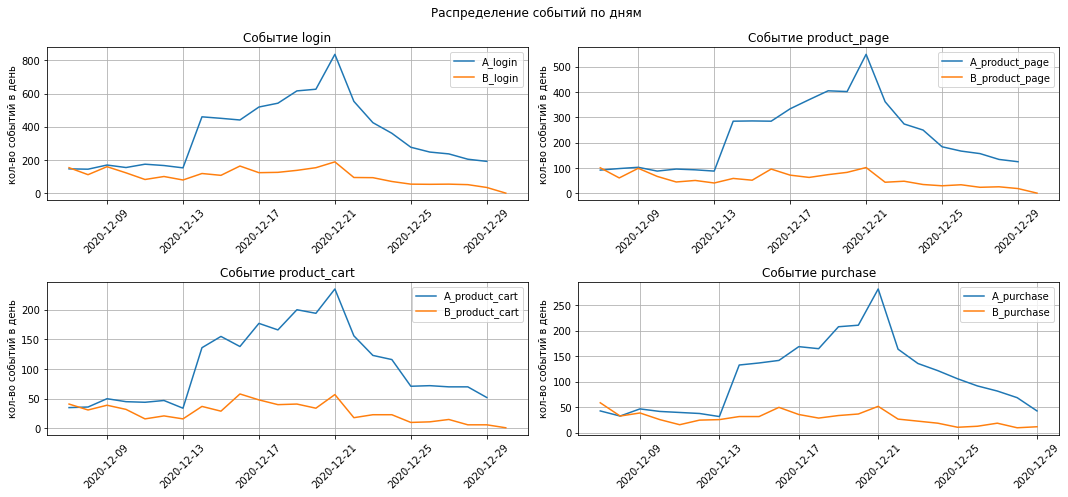

In [44]:
# строим график распределения событий по группам и по дням

fig, axs = plt.subplots(2,2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('Распределение событий по дням')

plt.subplot(221)
plt.plot(events_A['event_date'], events_A['login'], label = "A_login")
plt.plot(events_B['event_date'], events_B['login'], label = "B_login")
plt.legend()
plt.grid(True)
plt.xticks(rotation = 45)
plt.title('Событие login')
plt.ylabel('кол-во событий в день')

plt.subplot(222)
plt.plot(events_A['event_date'], events_A['product_page'], label = "A_product_page")
plt.plot(events_B['event_date'], events_B['product_page'], label = "B_product_page")
plt.legend()
plt.grid(True)
plt.xticks(rotation = 45)
plt.title('Событие product_page')
plt.ylabel('кол-во событий в день')

plt.subplot(223)
plt.plot(events_A['event_date'], events_A['product_cart'], label = "A_product_cart")
plt.plot(events_B['event_date'], events_B['product_cart'], label = "B_product_cart")
plt.legend()
plt.grid(True)
plt.xticks(rotation = 45)
plt.title('Событие product_cart')
plt.ylabel('кол-во событий в день')

plt.subplot(224)
plt.plot(events_A['event_date'], events_A['purchase'], label = "A_purchase")
plt.plot(events_B['event_date'], events_B['purchase'], label = "B_purchase")
plt.legend()
plt.grid(True)
plt.xticks(rotation = 45)
plt.title('Событие purchase')
plt.ylabel('кол-во событий в день')

plt.tight_layout()
plt.show()

**Выводы по графикам:**
* тренды распределения кол-ва событий по дням и по группам имеют схожие паттерны
* с начала эксперимента до 13 декабря значения между группами в метркиах близки и имеют схожие колебания друг относительно друга
* 13 декабря в группе А начинается взрывной рост
* 13 декабря в группе В начинается умеренный рост
* 21 декабря происходит пик для всех метрик в обеих группах
* темпы спада после пика в группе А такие же интенсивные как и на этапе роста
* группа В после 21 декабря также демонстрирует спад, но с более умеренным темпом
* к концу эксперимента группы опять сближаются, но так и не пересекаются

## Оценка результатов А/В тестирования

**Задача:**
* проверка статистической разницы долей z-критерием

In [45]:
# используем массив таблицы данных test_data_impact_check для проверки гипотез,
# разбиваем на группы

test_data_impact_check = test_data_impact_check.reset_index()
test_data_impact_check_A = test_data_impact_check[test_data_impact_check['group'] == 'a']
test_data_impact_check_B = test_data_impact_check[test_data_impact_check['group'] == 'b']

display(test_data_impact_check_A, test_data_impact_check_B)

event_name,group,login,product_cart,product_page,purchase,product_cart_impactconv,product_page_impactconv,purchase_impactconv
0,a,1515,458,962,462,0.30231,0.634983,0.30495


event_name,group,login,product_cart,product_page,purchase,product_cart_impactconv,product_page_impactconv,purchase_impactconv
1,b,639,187,365,183,0.292645,0.571205,0.286385


**Формулировка гипотез**

Для проверки статистической значимости различий конверсии между группами
формулируем гипотезы:

* **Гипотеза 0** = 'отличие между группами отсутствует & выявленная разница не является статистически достоверной'
* **Гипотеза 1** = 'существует отличие между группами & выявленная разница является статистически достоверной'

In [46]:
# создаем функцию определения статистической значимости  различий в 3-х группах
# используем поправку Бонферрони

def stat_sign_chek(successes, trials):
    alpha = 0.05/3 # определяем критический уровень стат значимости
    p1 = successes[0] / trials[0] # считаем пропорцию успехов в первой группе
    p2 = successes[1] / trials[1] # считаем пропорцию успехов во второй группе
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1]) # считаем пропорцию успехов в комбинированном датасете
    difference = p1 - p2 # определяем разницу пропорций в датасетоах
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])) # считаем статистику
                                                                                                    # в стандартных отклонениях
                                                                                                    # стандартного нормального
                                                                                                    # распределения
    distr = st.norm(0, 1) # задаем стандартное нормальное распределение
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    if (p_value < alpha):
        print('Отвергаем нулевыую гипотезу: между группами есть значимая разница.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.')
       
    return p_value

In [47]:
# производим проверку стат значимостиразницы различия конверсии метрики product_page
# между А/В группами с учетом поправки Бонферрони
#alpha = 0.05 / 3 = 0.0166666667

trials = np.array([test_data_impact_check_A['login'], test_data_impact_check_B['login']])
success = np.array([test_data_impact_check_A['product_page'], test_data_impact_check_B['product_page']])
    
stat_sign_chek(success, trials)

Отвергаем нулевыую гипотезу: между группами есть значимая разница.


array([0.00543366])

In [48]:
# производим проверку стат значимостиразницы различия конверсии метрики product_cart
# между А/В группами с учетом поправки Бонферрони
# alpha = 0.05 / 3 = 0.0166666667

trials = np.array([test_data_impact_check_A['login'], test_data_impact_check_B['login']])
success = np.array([test_data_impact_check_A['product_cart'], test_data_impact_check_B['product_cart']])
    
stat_sign_chek(success, trials)

Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.


array([0.65459946])

In [49]:
# производим проверку стат значимостиразницы различия конверсии метрики product_cart
# между А/В группами с учетом поправки Бонферрони
# alpha = 0.05 / 3 = 0.0166666667

trials = np.array([test_data_impact_check_A['login'], test_data_impact_check_B['login']])
success = np.array([test_data_impact_check_A['purchase'], test_data_impact_check_B['purchase']])
    
stat_sign_chek(success, trials)

Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.


array([0.39015605])

## Выводы
* результаты исследовательского анализа данных показали перимущество группы А (контрольной) в конверсии по всем целевым метрикам
* ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10% - не достигнут, преимущество осталось за контрольной группой
* результаты проверки статистической значимости различий на анализировавшемся датасете подтвердили наличие разницы в конверсии между контрольной и тестовой группами по метрике **product_page**, причем в отличии от ожиданий, контрольная группа показала лучший результат. По метрикам **product_cart** и **purchase** отличие между группами отсутствует.

**Существенные ошибки в организации теста, выявленные по результатам исследовательского анализа данных, а именно:**
1. отсутствие данных о действиях пользователей в период эксперимента, приведшие к потере 45% пользователей в общем и к критическому дисбалансу в группах
2. частичное отсутсствие данных за 30 декабря и полное отсутствие данных за период 31 декабря - 4 января 
3. пересечение эксперимента с топовой промоактивностью года
4. пересечение пользователей, закрепленных за тестом с другим тестом, также имеющим целью повлиять на конверсию

**позволяют не признать результаты теста.**

### Рекомендации

* при осуществлении **дизайна** теста обязательно включать **АА тест** для проверки качества деления, определения долей групп и подтверждения однородности трафика
* сверять сроки проведения тестов со сроками **промоактивностей**, не допускать наложения в случае возможности влияния на результат
* не допускать **параллельного проведения тестов с идентичными целями на пересекающихся аудиториях**
* выявить **причину отсутствия данных** и принять меры по ее устранению для будующих тестов